In [5]:
import librosa
import librosa.display
import librosa.feature
import soundfile
import os, glob, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from pycaret.classification import setup, compare_models, plot_model
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier









In [8]:
# ravdess data

wav_files = 'voice_file/'
ravdess_directory_list = os.listdir(wav_files)

file_emotion = []
file_path = []
temp = []

for dir in ravdess_directory_list:
    actor_files = os.listdir(os.path.join(wav_files, dir))
    for file in actor_files:
        part = file.split('.')[0]
        part = part.split('-')
        temp.append(part)
        file_path.append(wav_files + dir + '/' + file)
    for i in temp:
        if len(i) >= 3:  
            file_emotion.append(int(i[2]))  
        else:
            file_emotion.append(None)
            


path_df = pd.DataFrame(file_path, columns=['path'])
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])
emotion_df.dropna(inplace=True)

ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Original setup {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}

ravdess_df.emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'negative', 5:'negative', 6:'negative', 7:'negative', 8:'neutral'}, inplace=True)
ravdess_df['emotion_num'] = file_emotion


ravdess_df.dropna(inplace=True)
ravdess_df['emotions'].value_counts()

negative    768
neutral     480
happy       192
Name: emotions, dtype: int64

In [39]:
ravdess_df.emotion_num.replace({'neutral':1, 'happy':2, 'negative':3}, inplace=True)
# ravdess_df['emotions'].hist(grid=False , figsize=(5,3))

In [38]:
# crema data

crema_directory_list = os.listdir('Crema')

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append('Crema/' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)

crema_df['emotion_num'] = file_emotion
# Orginal {'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5 , 'fear':6, 'disgust':7, 'surprise':8}
crema_df['emotions'].replace({'neutral':'neutral', 'happy':'happy', 'sad':'negative', 'angry':'negative' , 'fear':'negative', 'disgust':'negative', 'surprise':'neutral'}, inplace=True)

# print(Crema_df.emotions.value_counts())
crema_df['emotions'].value_counts()

# crema_df['emotions'].hist(grid=False, figsize=(5,3))

negative    5079
happy       1270
neutral     1086
Name: emotions, dtype: int64

In [37]:
Tess = 'Tess/'
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])



# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])

tess_df = pd.concat([emotion_df, path_df], axis=1)
tess_df['emotion_num'] = file_emotion
tess_df['emotions'].replace({'neutral':'neutral', 'happy':'happy', 'sad':'negative', 'angry':'negative' , 'fear':'negative', 'disgust':'negative', 'surprise':'neutral'}, inplace=True)
tess_df['emotions'].value_counts()

# tess_df.emotions.hist(grid=False, figsize=(5,3))

negative    1600
neutral      800
happy        400
Name: emotions, dtype: int64

In [36]:
dir_list = os.listdir('Savee')

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
    elif i[-8:-6]=='sa':
        emotion.append('sad')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
    else:
        emotion.append('unknown') 
    path.append('Savee/' + i)

# Now check out the label count distribution 
savee_df = pd.DataFrame(emotion, columns = ['emotions'])
savee_df = pd.concat([savee_df, pd.DataFrame(path, columns = ['path'])], axis = 1)

savee_df['emotion_num'] = emotion
savee_df['emotions'].replace({'neutral':'neutral', 'happy':'happy', 'sad':'negative', 'angry':'negative' , 'fear':'negative', 'disgust':'negative', 'surprise':'neutral'}, inplace=True)

savee_df['emotions'].value_counts()
# savee_df.emotions.hist(grid=False, figsize=(5,3))

negative    240
neutral     180
happy        60
Name: emotions, dtype: int64

In [43]:
combined_df = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis=0)
combined_df['emotions'].value_counts()

negative    7687
neutral     2546
happy       1922
Name: emotions, dtype: int64

In [47]:
## Downsampling 

class_counts = combined_df['emotions'].value_counts()

# Determine the minority class count
minority_count = class_counts.min()

# Downsample the majority class
downsampled_df = pd.concat([combined_df[combined_df['emotions'] == class_name].sample(minority_count, replace=False) for class_name in class_counts.index])

# Shuffle the downsampled DataFrame to mix the classes
downsampled_df = downsampled_df.sample(frac=1).reset_index(drop=True)

# Now downsampled_df contains balanced classes


In [51]:
downsampled_df['emotions'].value_counts()

neutral     1922
happy       1922
negative    1922
Name: emotions, dtype: int64

## FEATURE EXTRACTION

In [6]:
# Extracting Features 

def extract_features(file_path):
    target_shape=(32,32)
    # Load the audio file
    y, sr = librosa.load(str(file_path))
    y, _ = librosa.effects.trim(y, top_db=30)
    
    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    rms_energy = librosa.feature.rms(y=y)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    stft = np.abs(librosa.stft(y))
    Mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y , sr=sr))
    # -------------------------------------------------------------------------
    # mel_spec = librosa.feature.melspectrogram(y=y , sr=sr)
    # mel_spec = resize(np.expand_dims(Mel_spectrogram,axis=-1),target_shape)


    # Calculate mean and standard deviation for each feature
    mfccs_mean = mfccs.mean(axis=1)
    mfccs_std = mfccs.std(axis=1)
    spectral_centroid_mean = spectral_centroid.mean(axis=1)
    spectral_bandwidth_mean = spectral_bandwidth.mean(axis=1)
    spectral_contrast_mean = spectral_contrast.mean(axis=1)
    zero_crossing_rate_mean = zero_crossing_rate.mean()
    rms_energy_mean = rms_energy.mean()
    stft_mean = np.mean(stft)
    mel_mean = np.mean(Mel_spectrogram)
    

    
     # Convert NumPy arrays to lists
    mfccs_mean = mfccs_mean.tolist()
    mfccs_std = mfccs_std.tolist()
    spectral_centroid_mean = spectral_centroid_mean.tolist()
    spectral_bandwidth_mean = spectral_bandwidth_mean.tolist()
    spectral_contrast_mean = spectral_contrast_mean.tolist()
    # chroma_mean = chroma_mean.tolist()
    stft_mean = stft_mean.tolist()
    mel_mean = mel_mean.tolist()
    
    

    # Create a dictionary with features
    features = {
        'mfccs_mean': mfccs_mean,
        'mfccs_std': mfccs_std,
        'spectral_centroid_mean': spectral_centroid_mean,
        'spectral_bandwidth_mean': spectral_bandwidth_mean,
        'spectral_contrast_mean': spectral_contrast_mean,
        'zero_crossing_rate_mean': zero_crossing_rate_mean,
        'rms_energy_mean': rms_energy_mean,
        # 'chroma_mean': chroma_mean,
        'stft_mean': stft_mean,
        'mel_mean': mel_mean
        # 'mel_spec': mel_spec
    }
    
    # Create lists to store values of each feature
    features_lists = []
    column_names = []
    for key, value in features.items():
        if isinstance(value, list):
            for i, v in enumerate(value):
                features_lists.append(v)
                column_names.append(f"{key}_{i+1}")
        else:
            features_lists.append(value)
            column_names.append(key)
    
    # Create DataFrame
    df_features = pd.DataFrame([features_lists], columns=column_names)
    
    return df_features

# Example usage:
# file_path = df['path'][0] 
# features = extract_features(file_path)
# features


In [87]:
feature_dfs = []
for file_path in downsampled_df['path']:
    features = extract_features(file_path)
    feature_dfs.append(features)

all_features = pd.concat(feature_dfs, ignore_index=True)

In [89]:
# df.reset_index(inplace=True, drop=True)
all_features.reset_index(inplace=True, drop=True)
df = pd.concat([all_features, downsampled_df['emotions']], axis=1)

In [91]:
# Saving df to csv 

df.to_csv('all_features_df.csv')

In [7]:
url = 'all_features_df.csv'

df = pd.read_csv(url)

In [8]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()


,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,...,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_mean_7,zero_crossing_rate_mean,rms_energy_mean,stft_mean,mel_mean,emotions
0,-378.901886,79.931244,6.794762,-16.559580,-5.094950,-3.094817,-13.449599,0.553072,-19.864174,-0.766525,...,22.869333,20.410791,20.192741,19.061475,50.429022,0.115936,0.030976,0.207066,0.307167,neutral
1,-467.452942,98.444489,-8.537258,-8.255068,4.670306,6.660696,-20.866158,-2.611037,-14.775223,1.990485,...,23.067121,18.842320,21.837341,19.289042,49.437678,0.104952,0.015762,0.093781,0.079595,neutral
2,-353.956848,84.252098,13.754623,28.255699,-4.182642,5.049757,-20.740187,-8.281658,-5.365039,-0.612106,...,17.421699,17.799570,19.276750,17.539842,53.382486,0.042174,0.093678,0.422558,4.351565,neutral
3,-401.145264,152.990051,21.830980,58.064377,-10.765795,17.926888,-17.022535,4.178920,-13.437823,-0.787367,...,18.526446,16.891653,17.462261,17.218963,63.102425,0.041178,0.022270,0.124423,0.172468,neutral
4,-279.561188,94.172615,6.634775,28.394228,13.229555,1.417930,-24.028566,-4.458006,-6.126031,-14.821184,...,21.857485,19.046101,21.988965,17.780934,52.204393,0.022151,0.195556,0.792444,15.763338,happy


In [9]:


X = df.drop(columns=['emotions'])  
y = df[['emotions']]  

print(y.shape, X.shape)

(5766, 1) (5766, 39)


In [10]:
y.value_counts()

emotions
happy       1922
negative    1922
neutral     1922
dtype: int64

In [11]:
# ## Encoding TEST

# one_hot_encoder = OneHotEncoder()

# x = one_hot_encoder.fit_transform(y)

In [12]:
# # TEST dummies
# y_ = pd.get_dummies(y) 

# y_

In [13]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train:',X_train.shape, y_train.shape ,'\n','Test:', X_test.shape, y_test.shape)


Train: (4612, 39) (4612, 1) 
 Test: (1154, 39) (1154, 1)


In [14]:
# Scalers

pt = PowerTransformer()
minScaler = MinMaxScaler()
stdScaler = StandardScaler()

# Normaliztiion 

pt.fit(X_train)
minScaler.fit(X_train)
stdScaler.fit(X_train)

# X_train_scaled = minScaler.transform(X_train)
# X_test_scaled = minScaler.transform(X_test)

# X_train_scaled = stdScaler.transform(X_train)
# X_test_scaled = stdScaler.transform(X_test)

# X_train_scaled = pt.transform(X_train)
# X_test_scaled = pt.transform(X_test)

X_train_scaled = pd.DataFrame(X_train, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test, columns=X.columns)



In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

clf = RandomForestClassifier(bootstrap=True,
                             max_depth=13,
                             n_estimators=40, 
                             # max_leaf_nodes=15,
                             min_samples_split=15,
                             max_features='sqrt')
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Train Accuracy: 0.914570685169124
Test Accuracy: 0.7079722703639515
Classification Report:
              precision    recall  f1-score   support

       happy       0.69      0.77      0.73       398
    negative       0.70      0.57      0.63       359
     neutral       0.73      0.77      0.75       397

    accuracy                           0.71      1154
   macro avg       0.71      0.70      0.70      1154
weighted avg       0.71      0.71      0.71      1154



In [16]:
# clf = ExtraTreesClassifier(bootstrap=False, max_depth=None, max_features='sqrt')    

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# # Generate a classification report
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

In [106]:
cv_scores = cross_val_score(clf, X_train, y_train, cv=7)
#gridsearch_cv 

for i, score in enumerate(cv_scores):
    print(f'fold {i+1}: {score}')

mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

fold 1: 0.6934749620637329
fold 2: 0.6904400606980273
fold 3: 0.723823975720789
fold 4: 0.7268588770864947
fold 5: 0.6722306525037937
fold 6: 0.6995447647951442
fold 7: 0.7082066869300911
Mean Accuracy: 0.7020828542568676


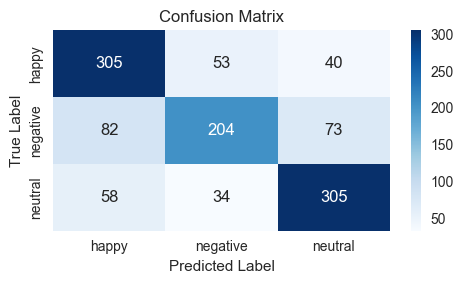

In [107]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

clases = ['happy', 'negative', 'neutral']

# Plot confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clases, yticklabels=clases)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [108]:
import joblib

final_model = RandomForestClassifier()

X_final = X
y_final = y

minScaler.fit(X)

# X_final = minScaler.transform(X_final)
X_final = pd.DataFrame(X_final, columns=X.columns)

final_model.fit(X_final, y_final)
joblib.dump(final_model, 'final_model.pkl')




['final_model.pkl']

In [109]:
final_model = joblib.load('final_model.pkl')

def run_pred(path):
    msg = extract_features(path)
    # msg_t = minScaler.transform(msg)
    msg_t = pd.DataFrame(msg, columns=X.columns)
    y_pred_ = final_model.predict(msg_t)
    
    print(y_pred_)
    return Audio(path)

In [123]:
run_pred('ira.ogg')

['negative']
